<a href="https://colab.research.google.com/github/Sohambasu07/fMRI_basic/blob/main/expt1_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''fMRI Experiment 1: ResNet50, 0.001 LR, 64 batch size, 0.9 momentum, (CrossEntropy Loss, SGD)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
datapath_root = "/content/drive/MyDrive/Alz_Classification"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import os
import matplotlib.pyplot as plt

In [ ]:
'''custom dataset path'''
class AlzDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_name)
        image = image.resize((64, 64), Image.ANTIALIAS)

        if self.transform:
            image = self.transform(image)
        label = 1 if "AD_Data" in self.root_dir else 0

        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
ad_datapath = "/content/drive/MyDrive/Alz_Classification/AD_Data"
cn_datapath = "/content/drive/MyDrive/Alz_Classification/CN_Data"

In [ ]:
ad_dataset = AlzDataset(root_dir=ad_datapath, transform=transform)
cn_dataset = AlzDataset(root_dir=cn_datapath, transform=transform)

full_dataset = torch.utils.data.ConcatDataset([ad_dataset, cn_dataset])


In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

'''train 70% (1866 images) val 20% (533 images) test 10% (267 images)'''
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


In [ ]:
import time

num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    average_train_loss = running_loss / len(train_loader)
    train_losses.append(average_train_loss)

    accuracy_train = correct_train / total_train
    train_accuracies.append(accuracy_train)

    #validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    average_val_loss = val_loss / len(val_loader)
    val_losses.append(average_val_loss)

    accuracy_val = correct_val / total_val
    val_accuracies.append(accuracy_val)

    end_time = time.time()
    epoch_time = end_time - start_time
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Time: {epoch_time:.2f} seconds, '
          f'Average Training Loss: {average_train_loss:.4f}, '
          f'Training Accuracy: {accuracy_train * 100:.2f}%, '
          f'Validation Loss: {average_val_loss:.4f}, '
          f'Validation Accuracy: {accuracy_val * 100:.2f}%')


<ipython-input-4-c79a389b9ca3>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((64, 64), Image.ANTIALIAS)


Epoch [1/50], Time: 961.68 seconds, Average Training Loss: 0.5845, Training Accuracy: 69.94%, Validation Loss: 0.5861, Validation Accuracy: 69.61%
Epoch [2/50], Time: 93.76 seconds, Average Training Loss: 0.3930, Training Accuracy: 81.40%, Validation Loss: 0.4191, Validation Accuracy: 80.68%
Epoch [3/50], Time: 94.25 seconds, Average Training Loss: 0.2170, Training Accuracy: 92.07%, Validation Loss: 0.3579, Validation Accuracy: 85.18%
Epoch [4/50], Time: 94.68 seconds, Average Training Loss: 0.1325, Training Accuracy: 95.23%, Validation Loss: 0.3208, Validation Accuracy: 86.87%
Epoch [5/50], Time: 93.96 seconds, Average Training Loss: 0.0579, Training Accuracy: 99.20%, Validation Loss: 0.3297, Validation Accuracy: 86.30%
Epoch [6/50], Time: 94.30 seconds, Average Training Loss: 0.0357, Training Accuracy: 99.62%, Validation Loss: 0.3031, Validation Accuracy: 88.37%
Epoch [7/50], Time: 94.87 seconds, Average Training Loss: 0.0754, Training Accuracy: 98.02%, Validation Loss: 0.4565, Valid

KeyboardInterrupt: ignored

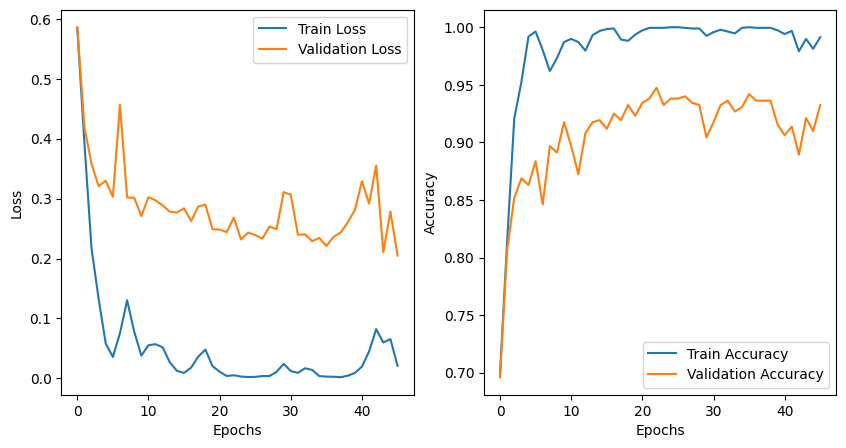

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

<ipython-input-4-c79a389b9ca3>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((64, 64), Image.ANTIALIAS)


Test Accuracy: 90.26%


In [ ]:
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

1866
267
533
